# Introduction

## Teguh Samudra, Siddharth Maheshwari

This project is based on a Kaggle Competition [Titanic Machine Learning from Disaster](https://www.kaggle.com/c/titanic)

# Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# Data Preparation

In [2]:
raw_data = pd.read_csv('datasets/train.csv')

In [3]:
raw_data.shape

(891, 12)

In [4]:
raw_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


There are 12 columns in the dataset, and our response variable is the column, **Survived**.
-	**PassengerId**: ID to distinguish between passengers
-	**Survived**:  0 - passenger did not survive the titanic mishap, 1 - passenger survived
-	**Pclass**: Ticket class
-	**Name**: Name of the passenger
-	**Sex**: gender
-	**Age**: Age of the passenger
-	**SibSp**: # of siblings/spouse aboard the ship
-	**Parch**: # of parents/children aboard the ship
-	**Ticket**: Ticket number
-	**Fare**: Fare paid for the cruise
-	**Cabin**: Cabin Number
-	**Embarked**: Port of embarkation; C = Cherbourg, Q = Queenstown, S = Southampton

In [5]:
# Data summary
raw_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Ford, Mr. William Neal",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


* Cabin column has only about 1/4 of the rows that is non-null value. This column would not be usefull 

* Name is also not a usefull to predict survival.

* Ticket number is not a useful indicator. Instead, we will use Pclass to determine the passenger's class

* Age has some missing values and we will remove these rows from the analysis. 


In [57]:
# Fill all NA values with blank
#raw_data.fillna("", inplace=True)
raw_data['Embarked'].fillna("", inplace=True)
raw_data['Cabin'].fillna("", inplace=True)
raw_data['Age'].fillna(value=0, inplace=True)

In [58]:
# Remove the 2 rows without detail of the place of embarkment
titanic = raw_data[raw_data['Embarked'] != ""]
titanic.shape

(889, 12)

We think columns *Age* and *Cabin* are useful, but there are lot of null values in both these columns. We thus need to find a way to tackle the null values. 

- For *Age* we can try calculating the median based on the person's title (Master, Mr, Ms, Mrs). We could also try it with a combination of sex, SibSp and Parch

- For *Cabin* we need only the cabin type the person has. Therefore, we will extract the cabin type i.e. first letter of the entry. Then to counter the missing values, we can first try looking at all people with the same ticket number and give them the same cabin type. If blanks still exist, we can look at a combination of fare and embarkement point. For people who have their cabin type available in the data we can extract the different ranges of fare for different cabin types based on the embarkment point. Then, using this information we predict the cabin type of the rest of the people.

## Treating Age

As discussed above, we will replace the missing values of Age with the median age for the title of that person. This will be a more accurate depiction than simply just taking the median of the entire dataset.

In [59]:
# Extract title from name
titanic['title'] = titanic['Name'].str.partition(',')[2].str.partition('.')[0]

C:\Users\sid05\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,Mr


In [61]:
# Check for unique titles
titanic['title'].unique()

array([' Mr', ' Mrs', ' Miss', ' Master', ' Don', ' Rev', ' Dr', ' Mme',
       ' Ms', ' Major', ' Lady', ' Sir', ' Mlle', ' Col', ' Capt',
       ' the Countess', ' Jonkheer'], dtype=object)

In [62]:
# No. of null values for column, age grouped by titles
age_null = titanic[titanic['Age'] == 0]
age_null.groupby(['title'])['PassengerId'].count()

title
 Dr          1
 Master      4
 Miss       36
 Mr        119
 Mrs        17
Name: PassengerId, dtype: int64

We have null value for column **Age** only for titles, *Dr, Master, Miss, Mr, and Mrs*. Let's get a median value of age for these titles.

In [63]:
# Get median value of age for different title values
age_notnull = titanic[titanic['Age'] != 0]
age_median = age_notnull.groupby(['title'])[['Age']].median()
age_median.rename(columns={'Age': 'MedianAge'}, inplace=True)
age_median.head()

,MedianAge
title,
Capt,70.0
Col,58.0
Don,40.0
Dr,46.5
Jonkheer,38.0


In [64]:
# Join with main dataframe
titanic = titanic.merge(age_median, on='title', how='left')

In [65]:
# Where ever age = 0 replace with median age
titanic['Age']= np.where(titanic['Age'] == 0, titanic['MedianAge'], titanic['Age'])
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,MedianAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,Mr,30.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,35.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,Miss,21.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,Mr,30.0


In [66]:
# Double Check if there are still any age=0 values in the dataframe
titanic[titanic['Age'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,MedianAge


Column **Age** has thus been treated

## Cabin

Before we talk about how to treat the cabin null values, let us answer we think this column is important. The type of cabin a person is staying in can be detrimental because it gives us the proxy location of the person and therefore, stipulate for example the distance of the person from the lifeboats. Below photo might give a better understanding.

<img src="Titanic_cutaway_diagram.png" alt="drawing" width="300"/>

Now coming to treating the null values. We will be using the following four steps to treat the null values.
 1. Extract the cabin type from the column i.e. the first letter of the value
 2. Calculate the range of fare for every cabin type from an embarkment point
 3. In case of the null values, first check if we have another row with the same ticket number and a non-null value. If we do we replace the cabin type with that value
 4. If we still have a blank value, we will decide the cabin type based on the where the fare of the ticket falls using our calculation in step 2


In [67]:
# Step 1: Extract the cabin type
titanic['CabinType'] = titanic['Cabin'].str[:1]
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,MedianAge,CabinType
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,Mr,30.0,
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,35.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,Miss,21.0,
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,35.0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,Mr,30.0,


In [70]:
# Step 2: Get ranges of fare for every cabin type embarkment combination
cabin_notnull = titanic[['Embarked', 'Pclass', 'CabinType', 'Ticket', 'Fare']][titanic['CabinType'] != ""]
print(cabin_notnull.shape)
cabin_fare_range = cabin_notnull.groupby(['Embarked', 'Pclass', 'CabinType']).agg({'Fare': ['min', 'max', 'mean', 'median']})
cabin_fare_range.rename(columns={'min': 'min_fare', 'max': 'max_fare'}, inplace=True)
cabin_fare_range

(202, 5)


Fare                                
                          min_fare  max_fare        mean    median
Embarked Pclass CabinType                                         
C        1      A          30.6958   56.9292   38.357743  35.50000
                B          27.7208  512.3292  145.964018  79.20000
                C          27.7500  227.5250   98.582533  89.10420
                D          63.3583  113.2750   85.586000  76.72920
                E          55.4417  134.5000   92.905840  83.15830
         2      D          12.8750   13.7917   13.333350  13.33335
         3      F          22.3583   22.3583   22.358300  22.35830
Q        1      C          90.0000   90.0000   90.000000  90.00000
         2      E          12.3500   12.3500   12.350000  12.35000
         3      F           7.7500    7.7500    7.750000   7.75000
S        1      A           0.0000   81.8583   40.731763  42.75000
                B           0.0000  211.3375   85.372283  86.50000
                C          26.5500  263.0000  101.630442  72.72500
                D          25.9292   77.9583   49.719906  52.20835
                E          25.5875   79.6500   46.448750  52.48125
                T          35.5000   35.5000   35.500000  35.50000
         2      D          13.0000   13.0000   13.000000  13.00000
                E          10.5000   13.0000   11.333333  10.50000
                F          10.5000   39.0000   23.750000  26.00000
         3      E           8.0500   12.4750   11.000000  12.47500
                F           7.6500    7.6500    7.650000   7.65000
                G          10.4625   16.7000   13.581250  13.58125

Based on the above table we see that we are not able to clearly distinguish the cabin type based on the fare, class and embarkment point as we had thought earlier.

In [71]:
# Step 3: Fill class based on the same ticket value
class_ticket = cabin_notnull.groupby(['Ticket', 'CabinType']).size()
class_ticket

Ticket             CabinType
110152             B            3
110413             E            3
110465             A            1
                   C            1
110564             C            1
110813             D            1
111240             B            1
111320             E            1
111361             B            2
111369             C            1
112050             A            1
112053             B            1
112058             B            1
112059             B            1
112277             A            1
113028             C            1
113043             C            1
113050             B            1
113051             C            1
113055             E            1
113056             A            1
113501             D            1
113503             C            1
113505             E            2
113509             B            1
113510             C            1
113514             C            1
113760             B            4
113767             

This may not work as we see that ticket numbers with different cabin types exist.

##### For now let's group all the people who do not have cabin together for cabin type

In [72]:
# Replace blank values of cabin type with 'unavilable'
titanic['CabinType'] = titanic['CabinType'].replace([""], 'Unavailable')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,MedianAge,CabinType
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,,S,Mr,30.0,Unavailable
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,35.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,,S,Miss,21.0,Unavailable
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,35.0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,,S,Mr,30.0,Unavailable


## Remove Unnecessary Columns

In [73]:
titanic = titanic.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'title', 'MedianAge'], axis = 1).dropna(axis = 0, how = 'any')
titanic.shape

(889, 9)

# Exploratory Data Analysis

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

## Distribution of Data

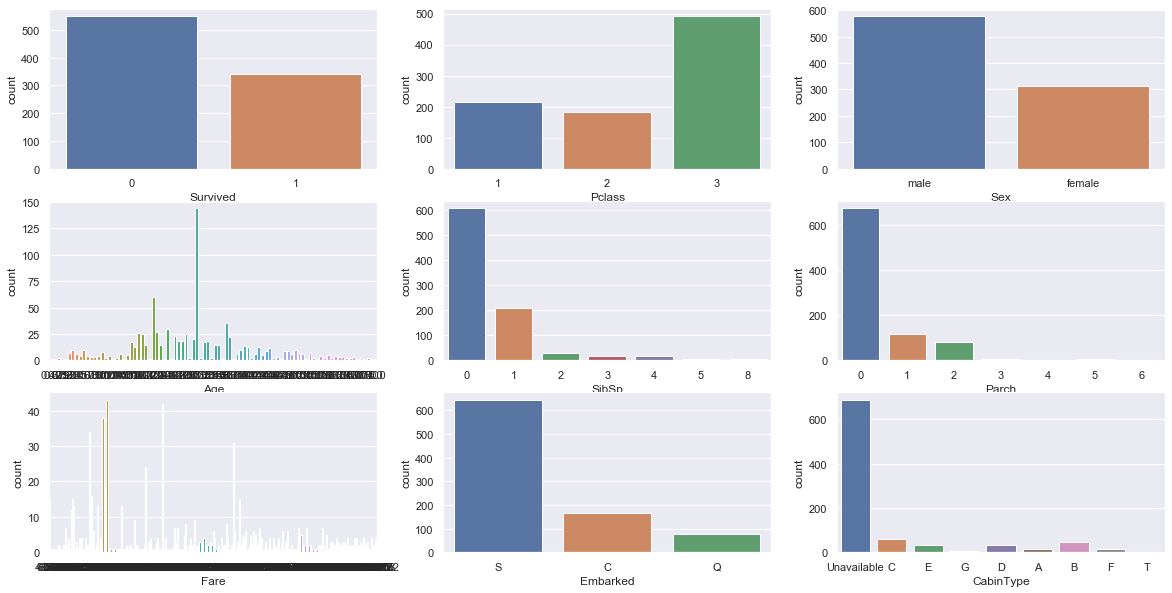

In [75]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))
for index, column in enumerate(titanic.columns):
    sns.countplot(titanic[column], ax = axes[index//3, index%3])

# Preprocessing for Machine Learning Algorithm

## Splitting Features and Target

In [76]:
from sklearn.model_selection import train_test_split

feature_full = titanic.drop(columns=['Survived'])
target_full = titanic[['Survived']]

feature_train, feature_test, target_train, target_test = train_test_split(feature_full,
                                                                          target_full,
                                                                          test_size = 0.2, 
                                                                          random_state = 21)

In [77]:
feature_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinType
862,2,male,24.0,0,0,13.0000,S,Unavailable
379,1,female,42.0,0,0,227.5250,C,Unavailable
723,1,male,27.0,1,0,53.1000,S,E
755,3,male,28.0,0,0,7.7958,S,Unavailable
503,1,female,16.0,0,0,86.5000,S,B


## Create a transformer to scale and dummify

In [78]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

categorical_features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'CabinType']
numeric_features = ['Age', 'Fare']

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), numeric_features),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


processed_array = preprocessor.fit_transform(feature_train).toarray()
colnames_dummified = preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features)

In [79]:
colnames_dummified

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male',
       'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5',
       'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4',
       'Parch_5', 'Parch_6', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'CabinType_A', 'CabinType_B', 'CabinType_C', 'CabinType_D',
       'CabinType_E', 'CabinType_F', 'CabinType_G', 'CabinType_T',
       'CabinType_Unavailable'], dtype=object)

## Transform training and testing feature

In [80]:
feature_train = pd.DataFrame(processed_array,
                            index = feature_train.index,
                            columns = numeric_features+list(colnames_dummified))

feature_test = pd.DataFrame(preprocessor.transform(feature_test).toarray(), 
                            index = feature_test.index, 
                            columns = feature_train.columns)

## Check Correlation

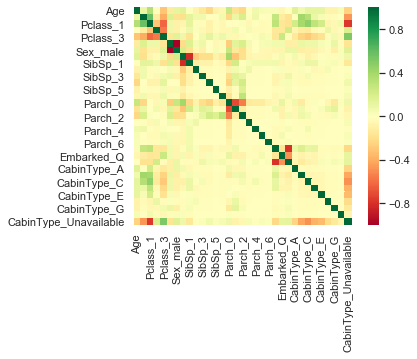

In [81]:
sns.heatmap(feature_train.corr(), square=True, cmap='RdYlGn')

# Algorithm selection

## Create Pipeline

In [82]:
# Pipeline 
from sklearn.pipeline import Pipeline


from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV, cross_validate

# Algorithm to try
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [83]:
pipe = Pipeline(
    [
        #('selector', SelectKBest(chi2, k = 5)),
        ('classifier', LogisticRegression(solver = 'lbfgs'))
    ]
)

In [84]:
search_space = [
    #{'selector__k' : [5, 10, 20, 100]},
    {'classifier': [LogisticRegression(solver = 'lbfgs')], 'classifier__C' : [0.01, 0.1, 1, 10]},
    {'classifier': [DecisionTreeClassifier()], 'classifier__max_depth': [1,5,10,15,30,50,70,100]},
    {'classifier': [RandomForestClassifier()], 'classifier__max_depth': [1,5,10,15,30,50,70,100], 
     'classifier__criterion' : ['gini', 'entropy']},
    {'classifier': [GradientBoostingClassifier()], 'classifier__max_depth': [0.01, 0.05, 0.1, 0.2, 0.5], 
     'classifier__min_samples_split': [5, 10, 25, 50, 75, 90], 'classifier__max_depth': [1,5,10], 
     'classifier__max_depth': [1,5,10], 'classifier__max_features': ['sqrt'],
     'classifier__subsample': [0.8], 'classifier__random_state': [10]},
    {'classifier': [KNeighborsClassifier()], 'classifier__n_neighbors': [1,5,10,15,30,50,70,100]}
    
]

In [85]:
clf = GridSearchCV(pipe, search_space, 
                   cv = 5, 
                   verbose = 0)

best_model = clf.fit(feature_train, 
                     target_train.values.ravel())

#https://stackoverflow.com/questions/34274598/does-gridsearchcv-store-all-the-scores-for-all-parameter-combinations

best_model.best_params_

C:\Users\sid05\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sid05\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sid05\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sid05\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\sid05\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic

{'classifier': GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=5,
                            max_features='sqrt', max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=10,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='auto',
                            random_state=10, subsample=0.8, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
 'classifier__max_depth': 5,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_split': 10,
 'classifier__random_state': 10,
 'classifier__subsample': 0.8}

In [86]:
best_model.best_score_

0.8143459915611815

In [89]:
# Model Score on test dataset
print(f"Test data - model score = {best_model.score(feature_test, target_test.values.ravel()):.2f}")

Test data - model score = 0.83


# Import test dataset provided

In [115]:
test_data = pd.read_csv('datasets/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [116]:
# apply all transformations

# Check for null values
test_data['Embarked'].fillna("", inplace=True)
test_data['Cabin'].fillna("", inplace=True)
test_data['Age'].fillna(value=0, inplace=True)

# Extract title from name
test_data['title'] = test_data['Name'].str.partition(',')[2].str.partition('.')[0]

# Replace null age values
test_data = test_data.merge(age_median, on='title', how='left')
test_data['Age']= np.where(test_data['Age'] == 0, test_data['MedianAge'], test_data['Age'])

# Extract the cabin type
test_data['CabinType'] = test_data['Cabin'].str[:1]
# Replace blank values of cabin type with 'unavilable'
test_data['CabinType'] = test_data['CabinType'].replace([""], 'Unavailable')

In [117]:
test_data.shape

(418, 14)

In [118]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          418 non-null object
Embarked       418 non-null object
title          418 non-null object
MedianAge      417 non-null float64
CabinType      418 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 49.0+ KB


Still have a null value in Fare. We will fix that before we move to prediction.

In [124]:
test_data[test_data[['Fare']].isnull().any(1)]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,MedianAge,CabinType
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,,S,Mr,30.0,Unavailable


In [121]:
# Replace with median fare for class 3 and Embarkment S
age_median = titanic.groupby(['Embarked', 'Pclass'])[['Fare']].median()
age_median

Fare
Embarked Pclass         
C        1       78.2667
         2       24.0000
         3        7.8958
Q        1       90.0000
         2       12.3500
         3        7.7500
S        1       52.0000
         2       13.5000
         3        8.0500

In [127]:
test_data['Fare'].fillna(value=8.05, inplace=True)

In [128]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          418 non-null object
Embarked       418 non-null object
title          418 non-null object
MedianAge      417 non-null float64
CabinType      418 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 49.0+ KB


In [129]:
# Drop unnecessary columns
test_data_model = test_data.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'title', 'MedianAge'], axis = 1).dropna(axis = 0, how = 'any')

In [130]:
test_data_model.shape

(418, 8)

In [131]:
# Model
# Scalar and vector transformation
test_data_model = pd.DataFrame(preprocessor.transform(test_data_model).toarray(), 
                            index = test_data_model.index, 
                            columns = feature_train.columns)

In [132]:
best_model.classes_

array([0, 1], dtype=int64)

In [133]:
# Predict survival probability
best_model.predict_proba(test_data_model)

array([[0.91938416, 0.08061584],
       [0.34155654, 0.65844346],
       [0.91496897, 0.08503103],
       [0.86312061, 0.13687939],
       [0.5088816 , 0.4911184 ],
       [0.84471977, 0.15528023],
       [0.81737389, 0.18262611],
       [0.83443456, 0.16556544],
       [0.18352902, 0.81647098],
       [0.92976662, 0.07023338],
       [0.8978203 , 0.1021797 ],
       [0.78235039, 0.21764961],
       [0.02034066, 0.97965934],
       [0.91080579, 0.08919421],
       [0.10161908, 0.89838092],
       [0.08161268, 0.91838732],
       [0.90289964, 0.09710036],
       [0.77942808, 0.22057192],
       [0.48542762, 0.51457238],
       [0.54181369, 0.45818631],
       [0.79426494, 0.20573506],
       [0.79168588, 0.20831412],
       [0.02705952, 0.97294048],
       [0.89614829, 0.10385171],
       [0.01145181, 0.98854819],
       [0.93520348, 0.06479652],
       [0.02206785, 0.97793215],
       [0.77942808, 0.22057192],
       [0.46906082, 0.53093918],
       [0.78905427, 0.21094573],
       [0.

In [140]:
# Predict result
test_data['Survived'] = best_model.predict(test_data_model)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,MedianAge,CabinType,Prediction,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,,Q,Mr,30.0,Unavailable,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,,S,Mrs,35.0,Unavailable,1,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,,Q,Mr,30.0,Unavailable,0,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,,S,Mr,30.0,Unavailable,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,,S,Mrs,35.0,Unavailable,0,0


In [141]:
# Submission file
submission = test_data[['PassengerId', 'Survived']]
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [142]:
# Write results
submission.to_csv("prediction_v1.csv", sep=',', index = False)